In [124]:
import MDAnalysis as mda

# Replace 'your_trajectory.gsd' with the actual path to your GSD file
u = mda.Universe('trajectory1.gsd')

# Now you can access the trajectory and topology information
# For example, to iterate over the frames:
# for ts in u.trajectory:
#     print(f"Frame: {ts.frame}, Time: {ts.time}")

# Accessing atom coordinates:
#print(u.atoms.positions)

# Note: If the GSD file contains varying numbers of particles or topologies, MDAnalysis may not handle it correctly.
# It's best suited for trajectories with fixed topology and number of particles. [14]

In [122]:
# for atom in u.atoms:
#     print(f"Atom ID: {atom.id}, Position: {atom.position}, Mass: {atom.mass}, Type: {atom.type}, Charge: {atom.charge}")

In [123]:
# dir(atom)

In [15]:
for angle in atom.angles:
    print(f"Angle: {angle}, Atoms: {angle.atoms}, Value: {angle.value()}")

Angle: <Angle between: Atom 97, Atom 98, Atom 99>, Atoms: <AtomGroup [<Atom 98: A of type A of resname 0, resid 0 and segid SYSTEM>, <Atom 99: A of type A of resname 0, resid 0 and segid SYSTEM>, <Atom 100: A of type A of resname 0, resid 0 and segid SYSTEM>]>, Value: 159.82548111749867


In [ ]:
dir(u)

In [21]:
u.bonds

<TopologyGroup containing 99 bonds>

In [22]:
u.dihedrals

<TopologyGroup containing 97 dihedrals>

In [23]:
u.angles

<TopologyGroup containing 98 angles>

In [24]:
u.impropers

<TopologyGroup containing 0 impropers>

#### Working on implementing the bond distribution calculation using MDAnalysis

In [121]:
# for bond in u.bonds:
#     print(f"Bond: {bond}, Atoms: {bond.atoms}, Length: {bond.length()}")

#### Reference Bond Distribution Function

In [113]:
import gsd.hoomd
import numpy as np
import warnings
from cmeutils.plotting import get_histogram

# This is the function that I need to convert into MDAnalysis
# It currently uses gsd.hoomd to load in the GSD file
# We want to use MDAnalysis to achieve the same functionality

def bond_distribution(
    gsd_file,
    A_name,
    B_name,
    start=0,
    stop=-1,
    histogram=False,
    l_min=0.0,
    l_max=4.0,
    normalize=True,
    bins=100,
):
    """Returns the bond length distribution for a given bond pair

    Parameters
    ----------
    gsdfile : str
        Filename of the GSD trajectory.
    A_name, B_name : str
        Name(s) of particles that form the bond pair
        (found in gsd.hoomd.Frame.particles.types)
    start : int
        Starting frame index for accumulating bond lengths.
        Negative numbers index from the end. (default 0)
    stop : int
        Final frame index for accumulating bond lengths. (default -1)
    histogram : bool, default=False
        If set to True, places the resulting bonds into a histogram
        and retrums the histogram's bin centers and heights as
        opposed to the actual calcualted bonds.
    l_min : float, default = 0.0
        Sets the minimum bond length to be included in the distribution
    l_max : float, default = 5.0
        Sets the maximum bond length value to be included in the distribution
    normalize : bool, default=False
        If set to True, normalizes the angle distribution by the
        sum of the bin heights, so that the distribution adds up to 1.
    bins : float, int, or str,  default="auto"
        The number of bins to use when finding the distribution
        of bond angles. Using "auto" will set the number of
        bins based on the ideal bin size for the data.
        See the numpy.histogram docs for more details.

    Returns
    -------
    1-D numpy.array  or 2-D numpy.array
        If histogram is False, Array of actual bond angles in degrees
        If histogram is True, returns a 2D array of bin centers and bin heights.

    """
    trajectory = gsd.hoomd.open(gsd_file, mode="r")
    name = "-".join([A_name, B_name])
    name_rev = "-".join([B_name, A_name])

    bonds = []
    for snap in trajectory[start:stop]:
        if name not in snap.bonds.types and name_rev not in snap.bonds.types:
            raise ValueError(
                f"Bond types {name} or {name_rev} not found "
                "snap.bonds.types."
            )
        for idx, bond in enumerate(snap.bonds.typeid):
            bond_name = snap.bonds.types[bond]
            if bond_name in [name, name_rev]:
                pos1 = snap.particles.position[snap.bonds.group[idx][0]]
                img1 = snap.particles.image[snap.bonds.group[idx][0]]
                pos2 = snap.particles.position[snap.bonds.group[idx][1]]
                img2 = snap.particles.image[snap.bonds.group[idx][1]]
                pos1_unwrap = pos1 + (img1 * snap.configuration.box[:3])
                pos2_unwrap = pos2 + (img2 * snap.configuration.box[:3])
                bonds.append(
                    np.round(np.linalg.norm(pos2_unwrap - pos1_unwrap), 3)
                )
                #print(bonds[idx])
    trajectory.close()

    print("meep")
    
    np.savetxt('bonds_cmeutils.csv', np.array(bonds), delimiter=',')

    if histogram:
        if min(bonds) < l_min or max(bonds) > l_max:
            warnings.warn(
                "There are bond lengths that fall outside of "
                "your set l_min and l_max range. You may want to adjust "
                "this range to include all bond lengths."
            )
        bin_centers, bin_heights = get_histogram(
            data=np.array(bonds),
            normalize=normalize,
            bins=bins,
            x_range=(l_min, l_max),
        )
        return np.stack((bin_centers, bin_heights)).T
    else:
        return np.array(bonds)

<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_10463/2339630742.py:24: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$L$[$\sigma$]")


meep


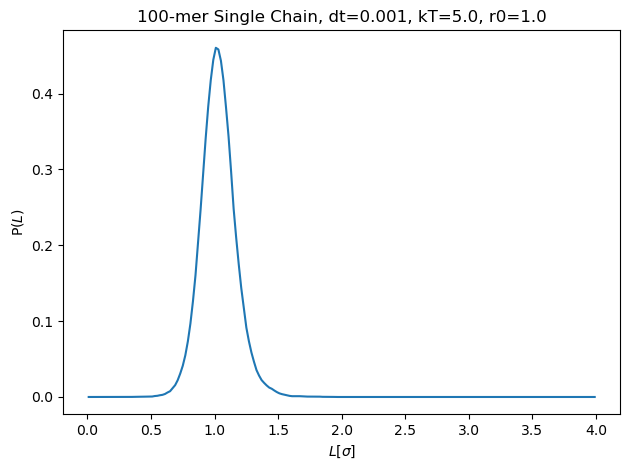

In [114]:
#from cmeutils.structure import bond_distribution
import matplotlib.pyplot as plt
from scipy import signal

fig = plt.figure()
chains = 1
bond = "AA"
nbins=200
weight_dist = np.zeros(nbins)
adist = bond_distribution(
    gsd_file = ("trajectory1.gsd"),
    A_name=bond[0],
    B_name=bond[1],
    histogram=True,
    normalize=True,
    start=0,
    bins=nbins
)
smooth = signal.savgol_filter(adist[:,1], window_length=7, polyorder=1)
weight_dist += smooth

plt.plot(adist[:,0], weight_dist/7, markersize=0)

plt.xlabel("$L$[$\sigma$]")
plt.ylabel("P($L$)")
plt.title("100-mer Single Chain, dt=0.001, kT=5.0, r0=1.0")
fig.tight_layout()

In [115]:
import numpy as np

# User will enter the 1-letter atom name for the bond
# I.E. bond between A and A particles
# NOTE this will not work if the name of the particles are not single letters

bond = "AA"

# What frame to start measuring bond info from
start = 0

# How many bins to use for the histogram
nbins = 200


A_name = bond[0]
B_name = bond[1]

# make the weight distribution for the histograms
weight_dist = np.zeros(nbins)

# generate the selection string so we only iterate over the atoms
# that can possibly participate in the desired bond
# I.E, if you have particles of type A, B, and C,
# You don't want to consider bonds that involve B and C atoms

selection_string =''

for letter in bond:
    selection_string += f"name {letter} or "

selection_string = selection_string[:-4]  # Remove the last ' or '
print(selection_string)

# Select atoms based on the selection string
relevent_atoms = u.select_atoms(selection_string)

name A or name A


In [116]:
#### Helper function from cmeutils.plotting.py to get histogram data
def get_histogram(data, normalize=False, bins="auto", x_range=None):
    """Bins a 1-D array of data into a histogram using
    the numpy.histogram method.

    Parameters
    ----------
    data : 1-D numpy.array, required
        Array of data used to generate the histogram
    normalize : boolean, default=False
        If set to true, normalizes the histogram bin heights
        by the sum of data so that the distribution adds
        up to 1
    bins : float, int, or str, default="auto"
        Method used by numpy to determine bin borders.
        Check the numpy.histogram docs for more details.
    x_range : (float, float), default = None
        The lower and upper range of the histogram bins.
        If set to None, then the min and max values of data are used.

    Returns
    -------
    bin_cetners : 1-D numpy.array
        Array of the bin center values
    bin_heights : 1-D numpy.array
        Array of the bin height values

    """
    bin_heights, bin_borders = np.histogram(
        a=data, bins=bins, range=x_range, density=normalize
    )
    bin_widths = np.diff(bin_borders)
    bin_centers = bin_borders[:-1] + bin_widths / 2
    return bin_centers, bin_heights

In [117]:
bond_name = "AA"

first_atom = bond_name[0]
second_atom = bond_name[1]

verbose = False

all_bonds = []

# Select atoms based on the selection string
for ts in u.trajectory[start:]:
    relevent_atoms = u.select_atoms(selection_string)

    for bond in relevent_atoms.bonds:
        bonded_atoms = list(bond.atoms.names)
        if first_atom in bonded_atoms and second_atom in bonded_atoms:
            # if verbose:
            #     #print(f"Bond: {bond}, Atoms: {bond.atoms}, Length: {bond.length()}")
            # else:
            #     #print(f"Bond Length: {bond.length()} between atoms {bond.atoms.ix}")
            all_bonds.append(bond.length())

# Plot the bond lengths as a histogram
import numpy as np
import warnings
import matplotlib.pyplot as plt

histogram = True
normalize = True

l_min = 0.0 # minimum bond length to include in the distribution
l_max = 4.0 # maximum bond length to include in the distribution

if histogram:
        if min(all_bonds) < l_min or max(all_bonds) > l_max:
            warnings.warn(
                "There are bond lengths that fall outside of "
                "your set l_min and l_max range. You may want to adjust "
                "this range to include all bond lengths."
            )
        bin_centers, bin_heights = get_histogram(
            data=np.array(all_bonds),
            normalize=normalize,
            bins=nbins,
            x_range=(l_min, l_max),
        )
        adist = np.stack((bin_centers, bin_heights)).T
else:
    adist = np.array(all_bonds)

In [118]:
from scipy import signal

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_10463/3536444080.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$L$[$\sigma$]")


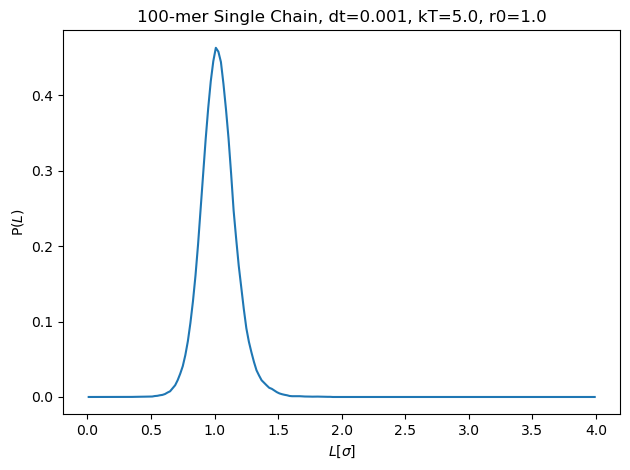

In [119]:
fig = plt.figure()

weight_dist = np.zeros(nbins)
smooth = signal.savgol_filter(adist[:,1], window_length=7, polyorder=1)
weight_dist += smooth

plt.plot(adist[:,0], weight_dist/7, markersize=0)

plt.xlabel("$L$[$\sigma$]")
plt.ylabel("P($L$)")
plt.title("100-mer Single Chain, dt=0.001, kT=5.0, r0=1.0")
fig.tight_layout()

#### Scratch for implementing angle distribution

<>:23: SyntaxWarning: invalid escape sequence '\T'
<>:24: SyntaxWarning: invalid escape sequence '\T'
<>:23: SyntaxWarning: invalid escape sequence '\T'
<>:24: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_10463/108504955.py:23: SyntaxWarning: invalid escape sequence '\T'
  plt.xlabel("$\Theta$ [rad]")
/tmp/ipykernel_10463/108504955.py:24: SyntaxWarning: invalid escape sequence '\T'
  plt.ylabel("P($\Theta$)")


Text(0, 0.5, 'P($\\Theta$)')

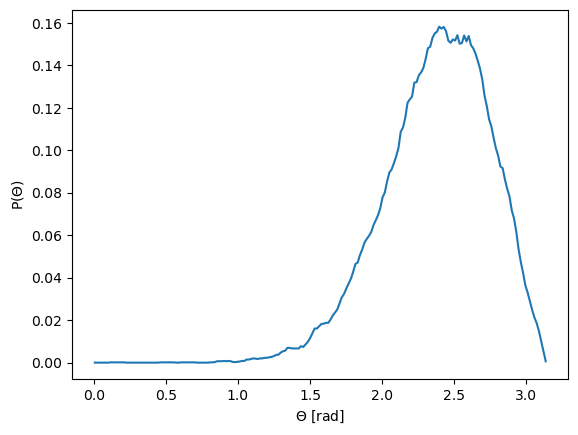

In [126]:
from cmeutils.structure import angle_distribution

fig = plt.figure()
chains = 1
angle = "AAA"
nbins = 200
weight_dist = np.zeros(nbins)
adist = angle_distribution(
    gsd_file = ("trajectory1.gsd"),
    A_name=angle[0],
    B_name=angle[1],
    C_name=angle[2],
    histogram=True,
    normalize=True,
    start =0,
    bins=nbins
    )
smooth = signal.savgol_filter(adist[:,1], window_length=7, polyorder=1)
weight_dist += smooth

plt.plot(adist[:,0], weight_dist/7, markersize=0)
    
plt.xlabel("$\Theta$ [rad]")
plt.ylabel("P($\Theta$)")

##### Angle function that needs to be rewritten in MDAnalysis

In [ ]:
def angle_distribution(
    gsd_file,
    A_name,
    B_name,
    C_name,
    start=0,
    stop=-1,
    degrees=False,
    histogram=False,
    theta_min=0.0,
    theta_max=None,
    normalize=False,
    bins="auto",
):
    """Returns the bond angle distribution for a given triplet of particles

    Parameters
    ----------
    gsdfile : str
        Filename of the GSD trajectory.
    A_name, B_name, C_name : str
        Name(s) of particles that form the angle triplet
        (found in gsd.hoomd.Frame.particles.types)
        They must be given in the same order as they form the angle
    start : int
        Starting frame index for accumulating bond lengths.
        Negative numbers index from the end. (default 0)
    stop : int
        Final frame index for accumulating bond lengths. (default -1)
    degrees : bool, default=False
        If True, the angle values are returned in degrees.
        if False, the angle values are returned in radians.
    histogram : bool, default=False
        If set to True, places the resulting angles into a histogram
        and retrums the histogram's bin centers and heights as
        opposed to the actual calcualted angles.
    theta_min : float, default = 0.0
        Sets the minimum theta value to be included in the distribution
    theta_max : float, default = None
        Sets the maximum theta value to be included in the distribution
        If left as None, then theta_max will be either pi radians or
        180 degrees depending on the value set for the degrees parameter
    normalize : bool, default=False
        If set to True, normalizes the angle distribution by the
        sum of the bin heights, so that the distribution adds up to 1.
    bins : float, int, or str,  default="auto"
        The number of bins to use when finding the distribution
        of bond angles. Using "auto" will set the number of
        bins based on the ideal bin size for the data.
        See the numpy.histogram docs for more details.

    Returns
    -------
    1-D numpy.array  or 2-D numpy.array
        If histogram is False, Array of actual bond angles in degrees
        If histogram is True, returns a 2D array of bin centers and bin heights.

    """
    if not degrees and theta_max is None:
        theta_max = np.pi
    elif degrees and theta_max is None:
        theta_max = 180

    trajectory = gsd.hoomd.open(gsd_file, mode="r")
    name = "-".join([A_name, B_name, C_name])
    name_rev = "-".join([C_name, B_name, A_name])

    angles = []
    for snap in trajectory[start:stop]:
        if name not in snap.angles.types and name_rev not in snap.angles.types:
            raise ValueError(
                f"Angles {name} or {name_rev} not found in "
                " snap.angles.types. "
                "A_name, B_name, C_name must match the order "
                "as they appear in snap.angles.types."
            )
        for idx, angle_id in enumerate(snap.angles.typeid):
            angle_name = snap.angles.types[angle_id]
            if angle_name == name or angle_name == name_rev:
                pos1 = snap.particles.position[snap.angles.group[idx][0]]
                img1 = snap.particles.image[snap.angles.group[idx][0]]
                pos2 = snap.particles.position[snap.angles.group[idx][1]]
                img2 = snap.particles.image[snap.angles.group[idx][1]]
                pos3 = snap.particles.position[snap.angles.group[idx][2]]
                img3 = snap.particles.image[snap.angles.group[idx][2]]
                pos1_unwrap = pos1 + (img1 * snap.configuration.box[:3])
                pos2_unwrap = pos2 + (img2 * snap.configuration.box[:3])
                pos3_unwrap = pos3 + (img3 * snap.configuration.box[:3])
                u = pos1_unwrap - pos2_unwrap
                v = pos3_unwrap - pos2_unwrap
                angles.append(
                    np.round(angle_between_vectors(u, v, False, degrees), 3)
                )
    trajectory.close()

    if histogram:
        if min(angles) < theta_min or max(angles) > theta_max:
            warnings.warn(
                "There are bond angles that fall outside of "
                "your set theta_min and theta_max range. "
                "You may want to adjust this range to "
                "include all bond angles."
            )
        bin_centers, bin_heights = get_histogram(
            data=np.array(angles),
            normalize=normalize,
            bins=bins,
            x_range=(theta_min, theta_max),
        )
        return np.stack((bin_centers, bin_heights)).T
    else:
        return np.array(angles)

##### Begin Joe Scratch

In [131]:
# Load the GSD file using MDAnalysis

fig = plt.figure()
chains = 1
angle = "AAA"
nbins = 200
weight_dist = np.zeros(nbins)

# parameters for the angle distribution function
gsd_file = "trajectory1.gsd"
A_name=angle[0]
B_name=angle[1]
C_name=angle[2]
histogram=True
normalize=True
start =0
stop=-1 # default is to use all frames
bins=nbins
degrees=False

theta_max = None  # default is None, will be set based on degrees
theta_min = 0.0

if not degrees and theta_max is None:
    theta_max = np.pi
elif degrees and theta_max is None:
    theta_max = 180

u = mda.Universe(gsd_file)


<Figure size 640x480 with 0 Axes>

In [ ]:
for angle in u.atoms.angles:
    print(f"Angle: {angle}, Atoms: {angle.atoms}, Value: {angle.value()}")

In [132]:

# generate the selection string so we only iterate over the atoms
# that can possibly participate in the desired bond
# I.E, if you have particles of type A, B, and C,
# You don't want to consider bonds that involve B and C atoms

selection_string = f"name {A_name} or name {B_name} or name {C_name}"

all_angles = []

# Select atoms based on the selection string
for ts in u.trajectory[start:stop]:
    relevent_atoms = u.select_atoms(selection_string)

    # Iterate over all of the angles in the selection from the universe
    for angle in relevent_atoms.angles:
        angled_atoms = list(angle.atoms.names)

        # Check if the bond contains both A_name and B_name
        if A_name in angled_atoms and B_name in angled_atoms:
            if degrees:
                all_angles.append(angle.value()) # by default this is in degrees
            else:
                all_angles.append(np.radians(angle.value()))

if histogram:
        if min(all_angles) < theta_min or max(all_angles) > theta_max:
            warnings.warn(
                "There are bond angles that fall outside of "
                "your set theta_min and theta_max range. "
                "You may want to adjust this range to "
                "include all bond angles."
            )
        bin_centers, bin_heights = get_histogram(
            data=np.array(all_angles),
            normalize=normalize,
            bins=bins,
            x_range=(theta_min, theta_max),
        )
        print(np.stack((bin_centers, bin_heights)).T)
else:
    print(np.array(all_angles))

[[0.00785398 0.        ]
 [0.02356194 0.        ]
 [0.03926991 0.        ]
 [0.05497787 0.        ]
 [0.07068583 0.        ]
 [0.0863938  0.        ]
 [0.10210176 0.        ]
 [0.11780972 0.        ]
 [0.13351769 0.        ]
 [0.14922565 0.        ]
 [0.16493361 0.00656174]
 [0.18064158 0.        ]
 [0.19634954 0.        ]
 [0.2120575  0.        ]
 [0.22776547 0.        ]
 [0.24347343 0.        ]
 [0.25918139 0.        ]
 [0.27488936 0.        ]
 [0.29059732 0.        ]
 [0.30630528 0.        ]
 [0.32201325 0.        ]
 [0.33772121 0.        ]
 [0.35342917 0.        ]
 [0.36913714 0.        ]
 [0.3848451  0.        ]
 [0.40055306 0.        ]
 [0.41626103 0.        ]
 [0.43196899 0.        ]
 [0.44767695 0.        ]
 [0.46338492 0.        ]
 [0.47909288 0.        ]
 [0.49480084 0.        ]
 [0.51050881 0.00656174]
 [0.52621677 0.        ]
 [0.54192473 0.        ]
 [0.5576327  0.        ]
 [0.57334066 0.        ]
 [0.58904862 0.        ]
 [0.60475659 0.        ]
 [0.62046455 0.        ]


In [120]:
# for angle in u.angles:
#     # print(f"Angle: {angle}, Atoms: {angle.atoms}, Value: {angle.value()}")